In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix


In [6]:
  df = pd.read_csv('/content/spam.csv', encoding='latin1')
  df = df[['v1', 'v2']]
  df.columns = ['label', 'message']
  df['label'] = df['label'].map({'spam': 1, 'ham': 0})
  df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


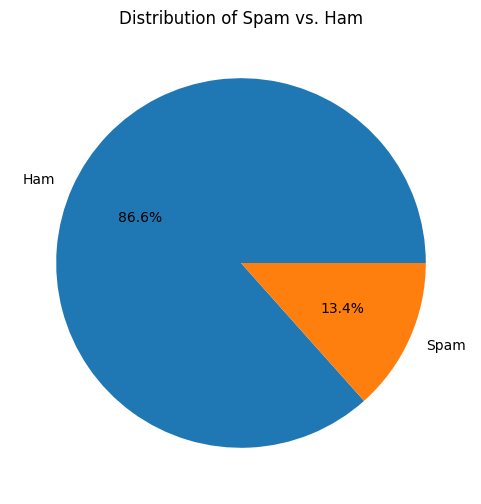

In [7]:
plt.figure(figsize=(6, 6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Ham', 'Spam'])
plt.title('Distribution of Spam vs. Ham')
plt.ylabel('')
plt.show()

In [10]:
df['message_length'] = df['message'].apply(len)
df

,label,message,message_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


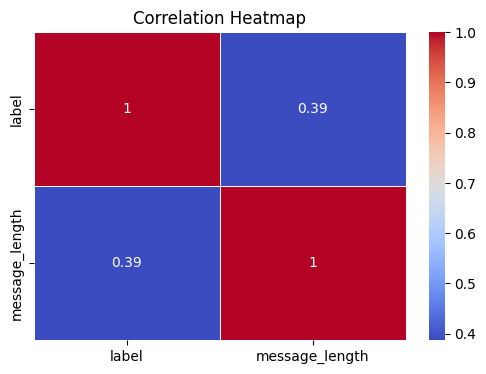

In [34]:
plt.figure(figsize=(6,4))
correlation_matrix = df[['label', 'message_length']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

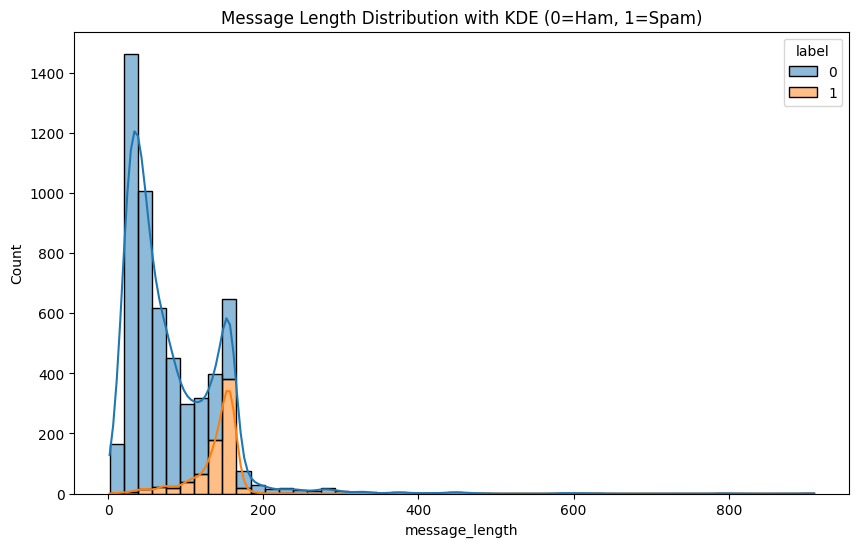

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_length', hue='label', kde=True, bins=50,multiple="stack")
plt.title('Message Length Distribution with KDE (0=Ham, 1=Spam)')
plt.show()


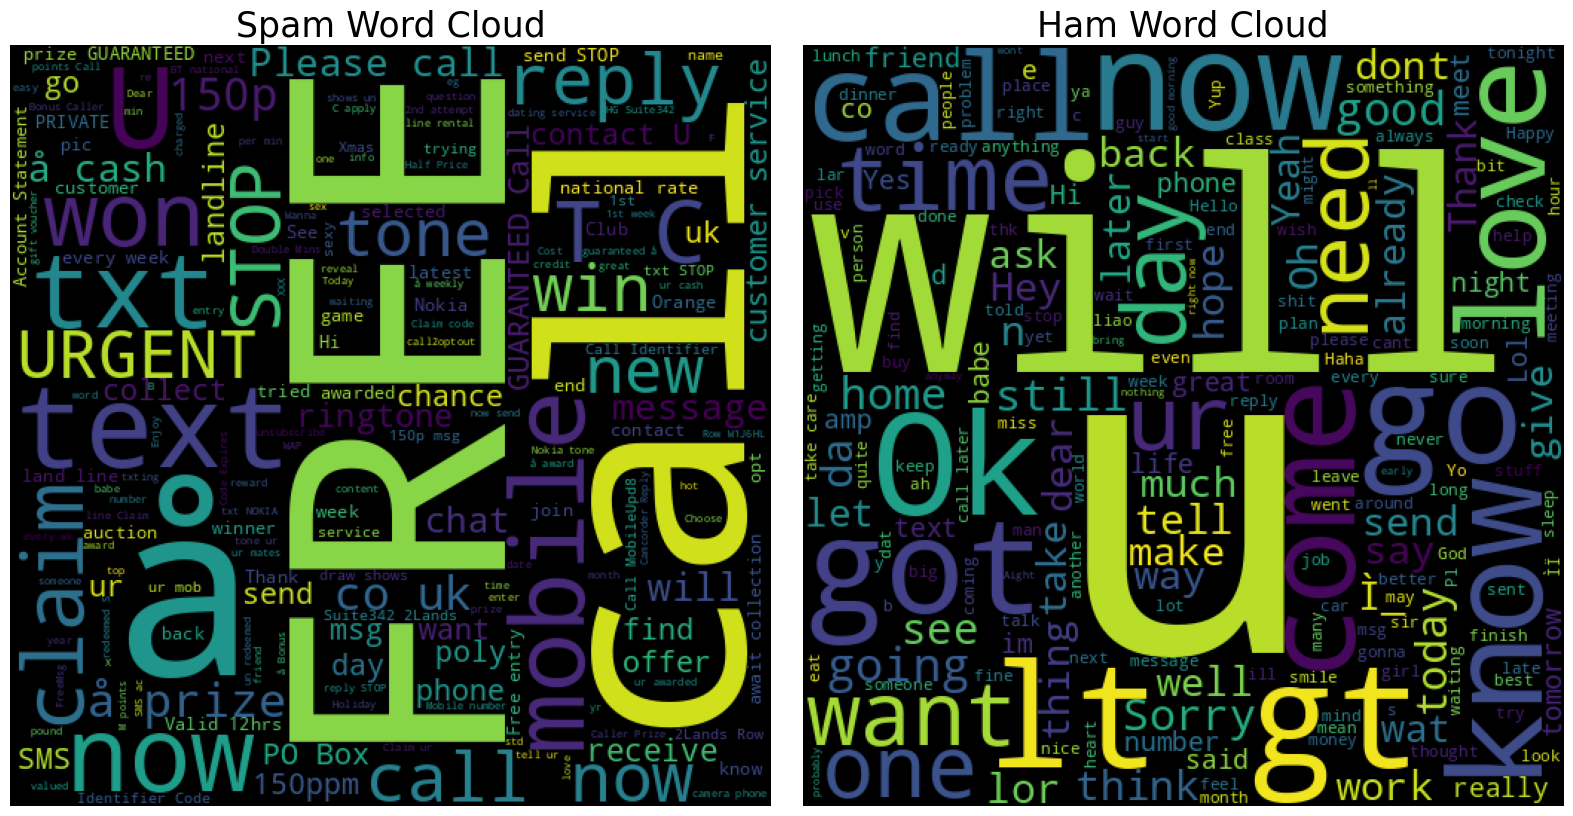

In [24]:
spam_words = ' '.join(list(df[df['label'] == 1]['message']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)

ham_words = ' '.join(list(df[df['label'] == 0]['message']))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(spam_wc)
plt.title("Spam Word Cloud",fontsize=25)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wc)
plt.title("Ham Word Cloud",fontsize=25)
plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

In [26]:
MAX_FEATURES = 2000
count_vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_train_count = count_vectorizer.fit_transform(X_train_text).toarray()
X_test_count = count_vectorizer.transform(X_test_text).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

In [36]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=500, reg_lambda=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Loss and regularization
            loss = (-1/n_samples) * np.sum(y * np.log(y_predicted) + (1-y) * np.log(1-y_predicted))
            l2_reg = (self.reg_lambda / (2 * n_samples)) * np.sum(np.square(self.weights))
            self.loss_history.append(loss + l2_reg)

            # Gradients
            dw = (1/n_samples) * (np.dot(X.T, (y_predicted - y)) + self.reg_lambda * self.weights)
            db = (1/n_samples) * np.sum(y_predicted - y)

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]


In [28]:
# Baseline
print("--- Baseline LR (CountVectorizer) ---")
lr_baseline = MyLogisticRegression()
lr_baseline.fit(X_train_count, y_train)
y_pred_baseline = lr_baseline.predict(X_test_count)
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_baseline))


--- Baseline LR (CountVectorizer) ---
Accuracy: 0.8655
Confusion Matrix:
 [[965   0]
 [150   0]]


In [29]:
# Feature Scaling
print("\n--- LR with Feature Scaling ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_count)
X_test_scaled = scaler.transform(X_test_count)
lr_scaled = MyLogisticRegression()
lr_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = lr_scaled.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_scaled):.4f}")


--- LR with Feature Scaling ---
Accuracy: 0.9874


In [30]:
# TfidfVectorizer
print("\n--- LR with TfidfVectorizer ---")
lr_tfidf = MyLogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")


--- LR with TfidfVectorizer ---
Accuracy: 0.8655



--- LR with L2 Regularization ---
Lambda = 0.01, Accuracy: 0.8655


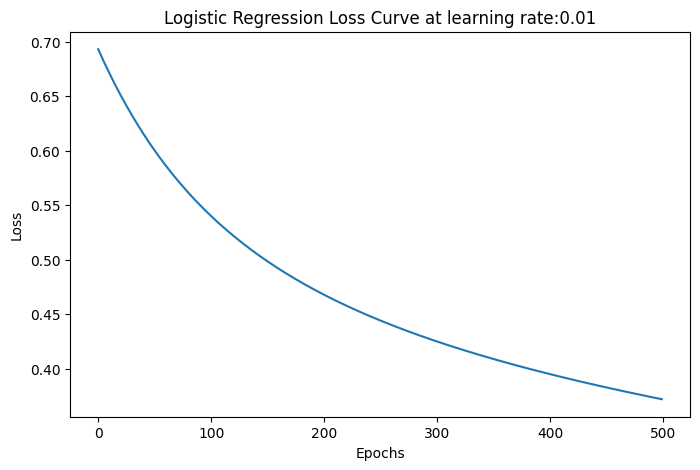

Lambda = 0.1, Accuracy: 0.8655


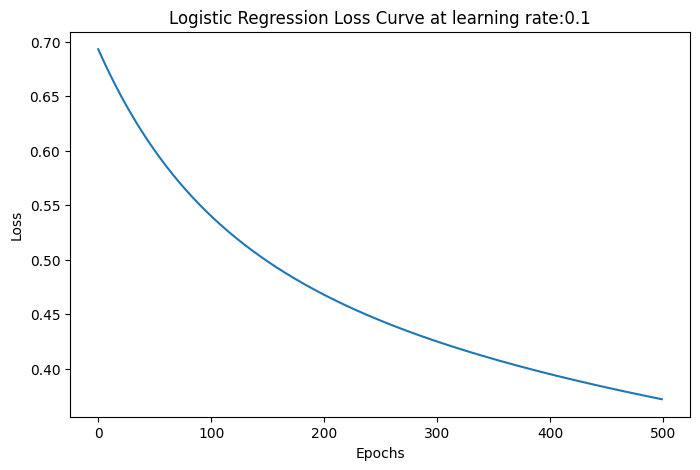

Lambda = 1, Accuracy: 0.8655


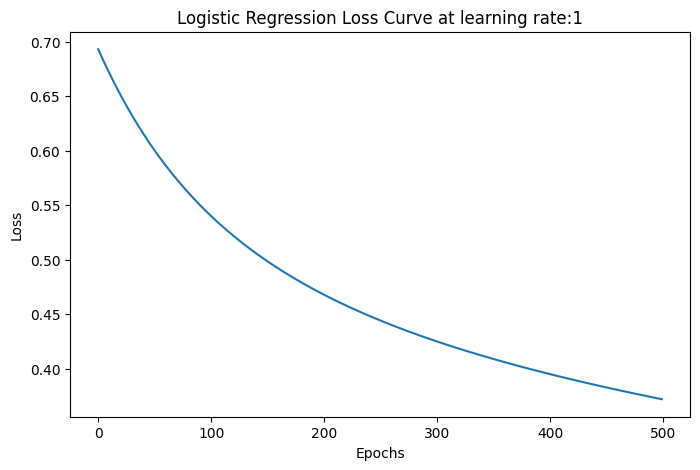

In [38]:
# Regularization
print("\n--- LR with L2 Regularization ---")
for l in [0.01, 0.1, 1]:
    lr_reg = MyLogisticRegression(reg_lambda=l)
    lr_reg.fit(X_train_count, y_train)
    y_pred_reg = lr_reg.predict(X_test_count)
    print(f"Lambda = {l}, Accuracy: {accuracy_score(y_test, y_pred_reg):.4f}")

    # Plotting loss curve
    plt.figure(figsize=(8,5))
    plt.plot(lr_baseline.loss_history)
    plt.title(f"Logistic Regression Loss Curve at learning rate:{l}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()